<a href="https://colab.research.google.com/github/Abuton/JanataHack-AnalyticsVidhya/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
import zipfile
import os


In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/data/train_data_cv.csv")
test_df = pd.read_csv("/content/drive/MyDrive/data/test_data_cv.csv")

train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


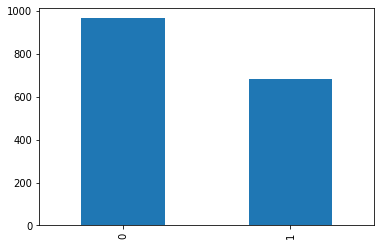

In [4]:
train_df['emergency_or_not'].value_counts().plot.bar();

In [5]:
import glob
data_path = "/content/drive/MyDrive/data/images/train_images"
path = os.path.join(data_path, "*.jpg")

In [6]:
path

'/content/drive/MyDrive/data/images/train_images/*.jpg'

In [7]:
import cv2
files = glob.glob(path)
data= []
for file in files:
  image = cv2.imread(file)
  data.append(image)
len(data)

1646

In [25]:
# 1. Collect all image name img_name = list
# 2. Create 2 folders (emergency/ not_emergency)
# 3. using csv data, separate images into the 2 new folders
#   3.1 loop img_name
    # 3.2 check if name is 0 or 1
    # append based on class

0

In [43]:
not_emergency = train_df[train_df['emergency_or_not'] == 0 ]
emergency = train_df[train_df['emergency_or_not'] == 1 ]
# not_emergency.drop('emergency_or_not', axis=1, inplace=True)

In [19]:
emergency.reset_index(drop=True, inplace=True)

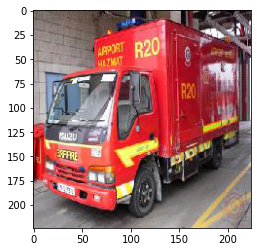

In [41]:
i = np.random.choice(emergency.index)
plt.imshow(plt.imread(data_path+"/"+str(emergency.image_names[i])))

In [44]:
import shutil

In [47]:
for e in not_emergency['image_names'].tolist(): 
    shutil.copy(f"/content/drive/MyDrive/data/images/train_images/{e}", 
                "/content/drive/MyDrive/data/images/train_images/not_emergency_images")
    
for e in emergency['image_names'].tolist(): 
    shutil.copy(f"/content/drive/MyDrive/data/images/train_images/{e}",
                "/content/drive/MyDrive/data/images/train_images/emergency_images")

In [62]:
train_df['emergency_or_not'] = train_df['emergency_or_not'].replace({1:"Emergency", 0:"Not_Emergency"})

In [63]:
from sklearn.model_selection import train_test_split
tr_data, val_data = train_test_split(train_df, test_size=.2, random_state=221)
tr_data = tr_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [50]:
len(tr_data)

1316

In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=15,
                            rescale=1./255,
                            # shear_range=.1,
                            # zoom_range=.2,
                            horizontal_flip=True,
                            width_shift_range=.1,
                            height_shift_range=.1)

In [72]:
IMAGE_SIZE = 128
batch_size = 64

In [73]:
train_generator = datagen.flow_from_directory(data_path, target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'binary', batch_size=batch_size)



Found 1646 images belonging to 2 classes.


In [64]:
train_generator_df = datagen.flow_from_dataframe(tr_data, data_path, x_col='image_names',
                                                   y_col='emergency_or_not', target_size= (300,300),
                                                   class_mode = 'binary', batch_size=batch_size)

# Validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(val_data, data_path,
                                                              x_col='image_names',
                                                   y_col='emergency_or_not', target_size= (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'binary', batch_size=batch_size)

Found 1316 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0


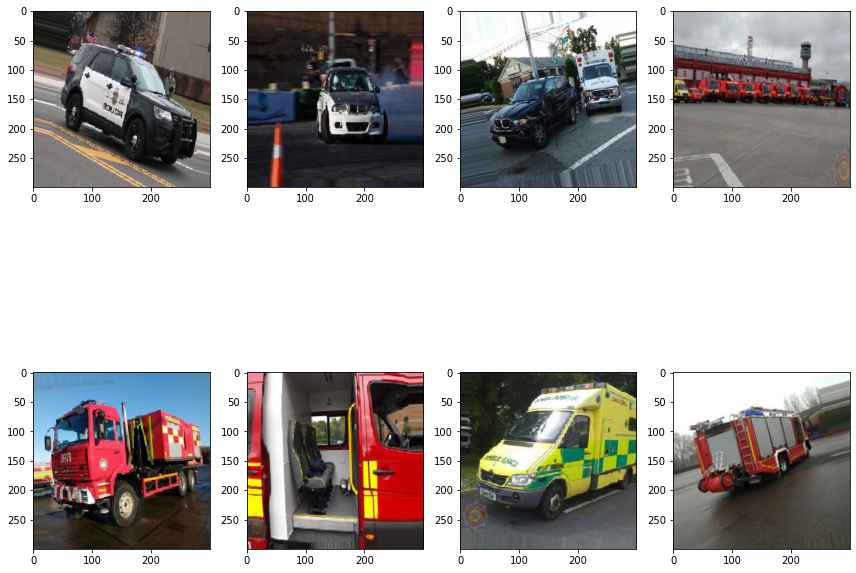

In [65]:
plt.figure(figsize=(12,12))
for i in range(0,8):
    plt.subplot(2, 4, i+1)
    for x_batch, y_batch in train_generator_df:
        image = x_batch[0]
        label = y_batch[0]
        print(label)
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [74]:
model = tf.keras.models.Sequential([
# Your Code Here
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  # tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [76]:
history = model.fit(train_generator, epochs=10, verbose=1)

Epoch 1/10
26/26 [==============================] - 26s 986ms/step - loss: 0.7007 - accuracy: 0.5911
Epoch 2/10
26/26 [==============================] - 26s 986ms/step - loss: 1.4364 - accuracy: 0.5765
Epoch 3/10
26/26 [==============================] - 26s 979ms/step - loss: 3.3327 - accuracy: 0.5772
Epoch 4/10
26/26 [==============================] - 26s 971ms/step - loss: 0.6370 - accuracy: 0.6817
Epoch 5/10
26/26 [==============================] - 26s 979ms/step - loss: 0.8198 - accuracy: 0.6677
Epoch 6/10
26/26 [==============================] - 26s 972ms/step - loss: 0.5664 - accuracy: 0.7400
Epoch 7/10
26/26 [==============================] - 26s 983ms/step - loss: 0.5584 - accuracy: 0.7290
Epoch 8/10
26/26 [==============================] - 26s 981ms/step - loss: 0.6796 - accuracy: 0.7139
Epoch 9/10
26/26 [==============================] - 26s 972ms/step - loss: 0.6019 - accuracy: 0.7278
Epoch 10/10
26/26 [==============================] - 26s 978ms/step - loss: 0.5138 - accura